# Criação do Pacote para o Aplicativo de Análise de Attrition

## Bibliotecas Utilizadas

In [254]:
# Bibliotecas de Sistema
import glob
import os
from zipfile import ZipFile
from copy import deepcopy
from pathlib import Path
from abc import ABC, abstractmethod
from __future__ import annotations
from typing import Dict, List, Tuple, Any
import warnings
from sklearn.exceptions import NotFittedError

# Manipulação de Dados
import pandas as pd
import numpy as np


#  Estatística
from scipy.stats import kendalltau
from statsmodels.stats.weightstats import ztest
from scipy.stats import chisquare

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import permutation_importance
import shap

# Processamento
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from feature_engine.encoding import OneHotEncoder, CountFrequencyEncoder


# Balanceamento
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTETomek


# Modelo
## Métricas de Validação
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

## Validação Cruzada e GridSearch
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

## Modelo em Árvore
import lightgbm as lgb





# Configurações Globais

warnings.simplefilter(action='ignore', category=FutureWarning)

sns.set_theme(style='darkgrid')
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (12, 8)


## Importação de Dados

In [78]:
data = pd.read_csv("attrition_data1.csv")

data.loc[data["Attrition"]=="Yes", "Attrition"] = 1
data.loc[data["Attrition"] == "No", "Attrition"] = 0
data[["Attrition"]] = data[["Attrition"]].astype("int")

x_train, x_test, y_train, y_test = train_test_split(data.drop(columns='Attrition'), data['Attrition'], test_size=0.2, random_state=13)

## Construção das Funcionalidades

In [79]:
# Classes Abstratas


class NumericalProcessor(ABC):
  @staticmethod
  @abstractmethod
  def process(self, data: Any):
      pass


class CategoricalProcessor(ABC):
  @staticmethod
  @abstractmethod
  def process(self, data: Any):
    pass

class NaNProcessor(ABC):
  @staticmethod
  @abstractmethod
  def process(self, data: Any):
    pass

class Model(ABC):
  @abstractmethod
  def fit(self, x_train, y_train):
    pass

  @abstractmethod
  def predict(self, x_test, y_test):
    pass

  @abstractmethod
  def predict_proba(self, x_test):
    pass

  @abstractmethod
  def score(self):
    pass

### Classes Concretas

#### Classe DataAttrition

In [80]:
class DataAttrition:
  """
  Classe criada para adaptar diversas formatos de arquivos e bases de dados\n
  para ser trabalhada na aplicação.

  Atributos:
  ----------
  data: Pandas DataFrame
    Base de dados a ser trabalhada. Podendo ser recebido a base de dados do pandas,\n
    ou o caminho de um arquivo, sendo possível ler e transformar as seguintes extensões\n
    em dataframe: csv, xlsx, xls, json e parquet.
  """
  def __init__(self, data: pd.DataFrame | Path | str) -> None:
    
    try:
      if isinstance(data, pd.DataFrame):
        self.data_frame = data
      elif isinstance(data, Path):
        self.data_frame = pd.read_csv(data.__str__())
      else:
        df_path_extension = os.path.splitext(data)[-1]
        if df_path_extension == '.csv':
          self.data_frame = pd.read_csv(data)
        elif df_path_extension == '.xlsx' or df_path_extension == '.xls':
          self.data_frame = pd.read_excel(data)
        elif df_path_extension == '.json':
          self.data_frame = pd.read_json(data)
        elif df_path_extension == '.parquet':
          self.data_frame = pd.read_parquet(data)
        else:
          raise ValueError('Extensão de arquivo não suportada.')

    except ValueError as e:
        print('O dado inserido é inválido.', e)


  def train_test_model_data(self, target_variable, test_size=0.2, random_state=0):
    x_train, x_test, y_train, y_test = train_test_split(self.data_frame.drop(columns=target_variable),
    self.data_frame[target_variable], test_size=test_size, random_state=random_state)
    return x_train, x_test, y_train, y_test


#### Classe Processamento Numérico

In [81]:
class AttNumProcess(NumericalProcessor):
  """
  Classe criada para trabalhar com dados numéricos.\n
  Atributos:
  ----------
  data: Pandas DataFrame
    Base de dados a ser trabalhada.
  
  """
  def __init__(self, data = None) -> None:
    self.target_variable = 'Attrition'
    if data is not None:
      self._data_frame = DataAttrition(data).data_frame
      try:
        self.num_data_frame = DataAttrition(data).data_frame.select_dtypes(include=np.number).drop(columns=self.target_variable)
      except KeyError:
        self.num_data_frame = DataAttrition(data).data_frame.select_dtypes(include=np.number)
    

  
  @property
  def data_frame(self) -> pd.DataFrame:
    return self._data_frame


  @data_frame.setter
  def data_frame(self, data: pd.DataFrame) -> None:
    self._data_frame = data

  def process(self, data=None, strategy='standard') -> pd.DataFrame:
    """
    Método para processar os dados numéricos.\n
    Parâmetros:
    ----------
    data: Pandas DataFrame
      Base de dados a ser trabalhada.
    strategy: str
      Estratégia de normalização.\n
    Opções:
    -------
    standard: StandardScaler
      Normalização padrão.
    min_max: MinMaxScaler
      Normalização de escala de 0 a 1.
    robust: RobustScaler
      Normalização de escala que utiliza estatísticas robustas a outliers.

    """

    #---------------------------------------------------------------#
    # Carrega a base de dados passada como argumento para o cálculo.

    if data is not None:
      self.__init__(data)

    #---------------------------------------------------------------#
    # Estratégias de normalização

    if strategy == 'standard':
      self.scaler = StandardScaler()
    elif strategy == 'min_max':
      self.scaler = MinMaxScaler()
    elif strategy == 'robust':
      self.scaler = RobustScaler()
    else:
      raise ValueError('Não foi possível encontrar a estratégia de normalização.')

    #---------------------------------------------------------------#
    # Normalização dos dados

    self.df_scaled = self.scaler.fit_transform(self.num_data_frame)
    self.df_scaled = pd.DataFrame(self.df_scaled, columns=self.num_data_frame.columns)
    self.data_frame[self.num_data_frame.columns] = self.df_scaled
    return self.df_scaled


  def inverse_process(self):
    """
    Método para inverter as transformações nos dados.\n
    Parâmetros:
    ----------
    data: Pandas DataFrame
      Base de dados a ser trabalhada.
    strategy: str
      Estratégia de normalização.\n
    Opções:
    -------
    standard_scaler: StandardScaler
      Normalização padrão.
    min_max_scaler: MinMaxScaler
      Normalização de escala de 0 a 1.
    robust_scaler: RobustScaler
      Normalização de escala que utiliza estatísticas robustas a outliers.

    """

    #---------------------------------------------------------------#
    # Carrega a base de dados passada como argumento para o cálculo.

    # if data is not None:
    #   self.__init__(data)

    #---------------------------------------------------------------#
    # Estratégias de normalização

    # if strategy == 'standard_scaler':
    #   scaler = StandardScaler()
    # elif strategy == 'min_max_scaler':
    #   scaler = MinMaxScaler()
    # elif strategy == 'robust_scaler':
    #   scaler = RobustScaler()
    # else:
    #   raise ValueError('Não foi possível encontrar a estratégia de normalização.')

    #---------------------------------------------------------------#
    # Inversão da normalização dos dados

    self.df_inv_scaled = self.scaler.inverse_transform(self.df_scaled)
    self.df_inv_scaled = pd.DataFrame(self.df_inv_scaled, columns=self.num_data_frame.columns)
    self.data_frame[self.num_data_frame.columns] = self.df_inv_scaled
    return self.df_inv_scaled


In [82]:
# TESTE AttNumProcess

df_num = deepcopy(data)

num_process = AttNumProcess(df_num)
num_process.process()
num_process.data_frame

df_num = num_process.data_frame

print(df_num.select_dtypes(include='object'))

print(df_num.head())

         BusinessTravel              Department EducationField  Gender  \
0         Travel_Rarely                   Sales  Life Sciences  Female   
1     Travel_Frequently  Research & Development  Life Sciences    Male   
2         Travel_Rarely  Research & Development          Other    Male   
3     Travel_Frequently  Research & Development  Life Sciences  Female   
4         Travel_Rarely  Research & Development        Medical    Male   
...                 ...                     ...            ...     ...   
1465  Travel_Frequently  Research & Development        Medical    Male   
1466      Travel_Rarely  Research & Development        Medical    Male   
1467      Travel_Rarely  Research & Development  Life Sciences    Male   
1468  Travel_Frequently                   Sales        Medical    Male   
1469      Travel_Rarely  Research & Development        Medical    Male   

                        JobRole MaritalStatus Over18 OverTime  
0               Sales Executive        Single  

#### Classe Processamento Categórico

In [83]:
class AttCatProcess(CategoricalProcessor):
  """
  Classe criada para trabalhar com dados categóricos.\n
  Atributos:
  ----------
  data: Pandas DataFrame
    Base de dados a ser trabalhada.

  """

  def __init__(self, data = None) -> None:
    if data is not None:
      self._data_frame = DataAttrition(data).data_frame

  @property
  def data_frame(self) -> pd.DataFrame:
    return self._data_frame

  @data_frame.setter
  def data_frame(self, data: pd.DataFrame):
    self._data_frame = data
  
  def clean_cat(self, data=None) -> pd.DataFrame:
    """
    Função que exclui variáveis categóricas com dado único.
    Parâmetros:
    ----------
    data: Pandas DataFrame
      Base de dados a ser trabalhada.
    """
    if data is not None:
      self.__init__(data)
    for column in self.data_frame.columns:
      if self.data_frame[column].nunique() == 1:
        self.data_frame.drop(column, axis=1, inplace=True)
    return self.data_frame
    
    
  def process(self, data=None, strategy='one_hot') -> pd.DataFrame:
    """
    Método para realizar o encoder dos dados categóricos.\n
    Parâmetros:
    ----------
    data: pd.DataFrame
      Base de dados a ser trabalhada.
    strategy: str
      Estratégia para a realização do encoder.\n
    Opções:
    -------
    one_hot: OneHotEncoder
      Realiza o encode nos valores das variáveis categóricas transformando-os\n
      em colunas de valores binários.
    label: LabelEncoder
      Realiza o encode nos valores das variáveis categóricas transformando-os\n
      em valores numéricos de 0 a numero_de_valores_da_classe-1.
    count_freq: CountFrequencyEncoder
      Substitui os valores categóricos pela porcentagem de ocorrência dos valores na categoria.
    """

    #---------------------------------------------------------------#
    # Caso um dataset seja passado no argumento, este será carregado na função\n
    # para a realização do cálculo.
    if data is not None:
      self.__init__(data)

    self.cat_data_frame = self.data_frame.select_dtypes(include='object')
    self.num_data_frame = self.data_frame.select_dtypes(include=np.number)

    #---------------------------------------------------------------#
    # Estratégias de encoder

    if strategy == 'one_hot':
      self.encoder = OneHotEncoder(drop_last=True)
    elif strategy == 'count_freq':
      self.encoder = CountFrequencyEncoder(encoding_method='frequency')
    else:
      raise ValueError('Não foi possível encontrar a estratégia para realizar o encoder.')

    #---------------------------------------------------------------#
    # Encoder dos dados
    self.cat_data_frame = self.encoder.fit_transform(self.cat_data_frame)

    self.data_frame = deepcopy(self.num_data_frame)
    self.data_frame[self.cat_data_frame.columns] = self.cat_data_frame

    return self.data_frame
    # return self.cat_data_frame

In [84]:
# TESTE AttCatProcess 
## 1.
df_cat = deepcopy(data)


cat_process = AttCatProcess(df_cat)

cat_process.process(strategy='one_hot')


cat_process.data_frame

,Age,Attrition,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,...,JobRole_Research Scientist,JobRole_Laboratory Technician,JobRole_Manufacturing Director,JobRole_Healthcare Representative,JobRole_Manager,JobRole_Sales Representative,JobRole_Research Director,MaritalStatus_Single,MaritalStatus_Married,OverTime_Yes
0,41,1,1102,1,2,1,1,2,94,3,...,0,0,0,0,0,0,0,1,0,1
1,49,0,279,8,1,1,2,3,61,2,...,1,0,0,0,0,0,0,0,1,0
2,37,1,1373,2,2,1,4,4,92,2,...,0,1,0,0,0,0,0,1,0,1
3,33,0,1392,3,4,1,5,4,56,3,...,1,0,0,0,0,0,0,0,1,1
4,27,0,591,2,1,1,7,1,40,3,...,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,36,0,884,23,2,1,2061,3,41,4,...,0,1,0,0,0,0,0,0,1,0
1466,39,0,613,6,1,1,2062,4,42,2,...,0,0,0,1,0,0,0,0,1,0
1467,27,0,155,4,3,1,2064,2,87,4,...,0,0,1,0,0,0,0,0,1,1
1468,49,0,1023,2,3,1,2065,4,63,2,...,0,0,0,0,0,0,0,0,1,0


In [85]:
## 2.
cat_process = AttCatProcess(df_num)

cat_process.process()


,Age,Attrition,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,...,JobRole_Research Scientist,JobRole_Laboratory Technician,JobRole_Manufacturing Director,JobRole_Healthcare Representative,JobRole_Manager,JobRole_Sales Representative,JobRole_Research Director,MaritalStatus_Single,MaritalStatus_Married,OverTime_Yes
0,0.446350,1,0.742527,-1.010909,-0.891688,0.0,-1.701283,-0.660531,1.383138,0.379672,...,0,0,0,0,0,0,0,1,0,1
1,1.322365,0,-1.297775,-0.147150,-1.868426,0.0,-1.699621,0.254625,-0.240677,-1.026167,...,1,0,0,0,0,0,0,0,1,0
2,0.008343,1,1.414363,-0.887515,-0.891688,0.0,-1.696298,1.169781,1.284725,-1.026167,...,0,1,0,0,0,0,0,1,0,1
3,-0.429664,0,1.461466,-0.764121,1.061787,0.0,-1.694636,1.169781,-0.486709,0.379672,...,1,0,0,0,0,0,0,0,1,1
4,-1.086676,0,-0.524295,-0.887515,-1.868426,0.0,-1.691313,-1.575686,-1.274014,0.379672,...,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,-0.101159,0,0.202082,1.703764,-0.891688,0.0,1.721670,0.254625,-1.224807,1.785511,...,0,1,0,0,0,0,0,0,1,0
1466,0.227347,0,-0.469754,-0.393938,-1.868426,0.0,1.723332,1.169781,-1.175601,-1.026167,...,0,0,0,1,0,0,0,0,1,0
1467,-1.086676,0,-1.605183,-0.640727,0.085049,0.0,1.726655,-0.660531,1.038693,1.785511,...,0,0,1,0,0,0,0,0,1,1
1468,1.322365,0,0.546677,-0.887515,0.085049,0.0,1.728317,1.169781,-0.142264,-1.026167,...,0,0,0,0,0,0,0,0,1,0


#### Classe Processamento Dados Nulos

In [129]:
class AttNaNProcess(NaNProcessor):
  def __init__(self, data = None) -> None:
    if data is not None:
      self._data_frame = DataAttrition(data).data_frame
    
  @property
  def data_frame(self) -> pd.DataFrame:
    return self._data_frame
  
  @data_frame.setter
  def data_frame(self, data: pd.DataFrame):
    self._data_frame = data


  def process(self, data=None, strategy='drop_0') -> pd.DataFrame:
    """
    Função para processar dados faltantes.
    Parâmetros:
    ----------
    data: Pandas DataFrame
      Base de dados a ser trabalhada.
    strategy: str
      Estratégia para a realização do cálculo.\n
    Opções:
    -------
    drop_1: Drop
      Exclui as variáveis que contém dados faltantes.
    drop_0: Drop
      Exclui os dados com variáveis faltantes.
    fill_mean:
      Substitui os dados numéricos faltantes pela média.
    fill_mode: 
      Substitui os dados numéricos faltantes pela moda.
    fill_median:
      Substitui os dados numéricos faltantes pela mediana.
    fill_mode_cat:
      Substitui os dados categóricos faltantes pela moda.

    """

    #---------------------------------------------------------------#
    # Caso um dataset seja passado no argumento, este será carregado na função\n
    # para a realização do cálculo.
    if data is not None:
      self.__init__(data)

    #---------------------------------------------------------------#
    # Separa o dado entre variáveis numéricas e categóricas
    try:
      num_data_frame = self.data_frame.select_dtypes(include=np.number).drop(columns='Attrition')
    except:
      num_data_frame = self.data_frame.select_dtypes(include=np.number)
    cat_data_frame = self.data_frame.select_dtypes(include=['object'])

    
    #---------------------------------------------------------------#
    # Estratégias de processamento
    if strategy == 'drop_0':
      self.data_frame.dropna(inplace=True, axis=0)
      return self.data_frame
    
    elif strategy == 'drop_1':
      self.data_frame.dropna(inplace=True, axis=1)
      return self.data_frame

    elif strategy == 'mean':

      self.data_frame[num_data_frame.columns] = num_data_frame.apply(lambda x: x.fillna(x.mean()))
      return self.data_frame


    elif strategy == 'mode':
      self.data_frame[num_data_frame.columns] = num_data_frame.apply(lambda x: x.fillna(x.mode().iloc[0]))
      return self.data_frame

    elif strategy == 'median':
      self.data_frame[num_data_frame.columns] = num_data_frame.apply(lambda x: x.fillna(x.median()))
      return self.data_frame

    elif strategy == 'mode_cat':
      self.data_frame[cat_data_frame.columns] = cat_data_frame.apply(lambda x: x.fillna(x.mode().iloc[0]))
      return self.data_frame
    else:
      raise ValueError('Não foi possível encontrar a estratégia de imputação.')



In [87]:
# TESTE AttNaNProcess

df_nan = deepcopy(data)
df_nan[1400:1550] = np.nan

In [88]:
nan_process = AttNaNProcess(df_nan)

nan_process.process(strategy='mode')
nan_process.process(strategy='mode_cat')

nan_process.data_frame

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41.0,1.0,Travel_Rarely,1102.0,Sales,1.0,2.0,Life Sciences,1.0,1.0,...,1.0,80.0,0.0,8.0,0.0,1.0,6.0,4.0,0.0,5.0
1,49.0,0.0,Travel_Frequently,279.0,Research & Development,8.0,1.0,Life Sciences,1.0,2.0,...,4.0,80.0,1.0,10.0,3.0,3.0,10.0,7.0,1.0,7.0
2,37.0,1.0,Travel_Rarely,1373.0,Research & Development,2.0,2.0,Other,1.0,4.0,...,2.0,80.0,0.0,7.0,3.0,3.0,0.0,0.0,0.0,0.0
3,33.0,0.0,Travel_Frequently,1392.0,Research & Development,3.0,4.0,Life Sciences,1.0,5.0,...,3.0,80.0,0.0,8.0,3.0,3.0,8.0,7.0,3.0,0.0
4,27.0,0.0,Travel_Rarely,591.0,Research & Development,2.0,1.0,Medical,1.0,7.0,...,4.0,80.0,1.0,6.0,3.0,3.0,2.0,2.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,34.0,NaN,Travel_Rarely,691.0,Research & Development,2.0,3.0,Life Sciences,1.0,1.0,...,3.0,80.0,0.0,10.0,2.0,3.0,5.0,2.0,0.0,2.0
1466,34.0,NaN,Travel_Rarely,691.0,Research & Development,2.0,3.0,Life Sciences,1.0,1.0,...,3.0,80.0,0.0,10.0,2.0,3.0,5.0,2.0,0.0,2.0
1467,34.0,NaN,Travel_Rarely,691.0,Research & Development,2.0,3.0,Life Sciences,1.0,1.0,...,3.0,80.0,0.0,10.0,2.0,3.0,5.0,2.0,0.0,2.0
1468,34.0,NaN,Travel_Rarely,691.0,Research & Development,2.0,3.0,Life Sciences,1.0,1.0,...,3.0,80.0,0.0,10.0,2.0,3.0,5.0,2.0,0.0,2.0


#### Classe Pipeline de Processamento

In [206]:
class AttProcessPipeline:
  def __init__(self, data: pd.DataFrame) -> None:
    self.data = data
    
    self._already_processed = False
    self.num_strategy = 'standard'
    self.cat_strategy = 'one_hot'
    self.nan_strategy = 'mode'

  def _unique_value_feat(self):
    """
    Função para calcular a quantidade de valores únicos de cada variável.
    """
    unique_value_feat = self.data.nunique()
    columns_to_drop = [index for index in unique_value_feat.index if unique_value_feat[index] == 1]
    self.data.drop(columns_to_drop, axis=1, inplace=True)


  def process(self):
    """
    Função para processar os dados.
    """
    if self._already_processed:
      return self.data
    # Colunas Categóricas
    self.cat_columns = self.data.select_dtypes(include=['object']).columns

    # Colunas numéricas
    self.num_columns = self.data.select_dtypes(include=np.number).columns

    self.nan_processor = AttNaNProcess(self.data)
    if self.nan_strategy == 'mode' or self.nan_strategy == 'mode_cat':
      self.nan_processor.process(strategy='mode')
      self.nan_processor.process(strategy='mode_cat')
    else:
      self.nan_processor.process(strategy=self.nan_strategy)

    if not self.nan_processor.data_frame.columns.tolist():
      raise ValueError('O valor do conjunto de dados é nulo.')
    # return self.nan_processor.data_frame
      
    self._unique_value_feat()
    
    self.num_processor = AttNumProcess(self.data)
    self.num_processor.process(strategy=self.num_strategy)
    self.data = self.num_processor.data_frame

    if self.cat_columns.tolist():
      self.cat_processor = AttCatProcess(self.data)
      self.cat_processor.process(strategy=self.cat_strategy)
      self.data = self.cat_processor.data_frame

    self._already_processed = True

    # self.nan_processor = AttNaNProcess(self.data)


    return self.data


  def inverse_process(self):
    """
    Função para reverter o processamento.
    """
    if not self._already_processed:
      return self.data
    inverse_data = self.num_processor.inverse_process()
    self.data[inverse_data.columns] = inverse_data

    self._already_processed = False
    return self.data
    

In [207]:
# TESTE AttProcessPipeline

df_ = deepcopy(data)

df_[1400: 1500] = np.nan

pipeline = AttProcessPipeline(df_)

pipeline.nan_strategy = 'mode'
pipeline.num_strategy = 'standard'
pipeline.cat_strategy = 'one_hot'


pipeline.process()



,Age,Attrition,DailyRate,DistanceFromHome,Education,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,...,JobRole_Research Scientist,JobRole_Laboratory Technician,JobRole_Manufacturing Director,JobRole_Healthcare Representative,JobRole_Manager,JobRole_Sales Representative,JobRole_Research Director,MaritalStatus_Single,MaritalStatus_Married,OverTime_Yes
0,0.469036,1.0,0.761949,-0.979213,-0.914546,-1.555517,-0.684787,1.419150,0.365694,-0.015367,...,0,0,0,0,0,0,0,1,0,1
1,1.360561,0.0,-1.326053,-0.103487,-1.913344,-1.553840,0.252491,-0.245936,-1.067825,-0.015367,...,1,0,0,0,0,0,0,0,1,0
2,0.023274,1.0,1.449493,-0.854109,-0.914546,-1.550487,1.189770,1.318236,-1.067825,-0.918918,...,0,1,0,0,0,0,0,1,0,1
3,-0.422489,0.0,1.497697,-0.729006,1.083050,-1.548810,1.189770,-0.498221,0.365694,-0.918918,...,1,0,0,0,0,0,0,0,1,1
4,-1.091133,0.0,-0.534490,-0.854109,-1.913344,-1.545457,-1.622066,-1.305536,0.365694,-0.918918,...,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,-0.311048,NaN,-0.280784,-0.854109,0.084252,-1.555517,0.252491,0.006350,0.365694,-0.918918,...,0,0,0,0,0,0,0,0,1,0
1466,-0.311048,NaN,-0.280784,-0.854109,0.084252,-1.555517,0.252491,0.006350,0.365694,-0.918918,...,0,0,0,0,0,0,0,0,1,0
1467,-0.311048,NaN,-0.280784,-0.854109,0.084252,-1.555517,0.252491,0.006350,0.365694,-0.918918,...,0,0,0,0,0,0,0,0,1,0
1468,-0.311048,NaN,-0.280784,-0.854109,0.084252,-1.555517,0.252491,0.006350,0.365694,-0.918918,...,0,0,0,0,0,0,0,0,1,0


In [209]:
pipeline.process()

,Age,Attrition,DailyRate,DistanceFromHome,Education,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,...,JobRole_Research Scientist,JobRole_Laboratory Technician,JobRole_Manufacturing Director,JobRole_Healthcare Representative,JobRole_Manager,JobRole_Sales Representative,JobRole_Research Director,MaritalStatus_Single,MaritalStatus_Married,OverTime_Yes
0,0.469036,1.0,0.761949,-0.979213,-0.914546,-1.555517,-0.684787,1.419150,0.365694,-0.015367,...,0,0,0,0,0,0,0,1,0,1
1,1.360561,0.0,-1.326053,-0.103487,-1.913344,-1.553840,0.252491,-0.245936,-1.067825,-0.015367,...,1,0,0,0,0,0,0,0,1,0
2,0.023274,1.0,1.449493,-0.854109,-0.914546,-1.550487,1.189770,1.318236,-1.067825,-0.918918,...,0,1,0,0,0,0,0,1,0,1
3,-0.422489,0.0,1.497697,-0.729006,1.083050,-1.548810,1.189770,-0.498221,0.365694,-0.918918,...,1,0,0,0,0,0,0,0,1,1
4,-1.091133,0.0,-0.534490,-0.854109,-1.913344,-1.545457,-1.622066,-1.305536,0.365694,-0.918918,...,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,-0.311048,NaN,-0.280784,-0.854109,0.084252,-1.555517,0.252491,0.006350,0.365694,-0.918918,...,0,0,0,0,0,0,0,0,1,0
1466,-0.311048,NaN,-0.280784,-0.854109,0.084252,-1.555517,0.252491,0.006350,0.365694,-0.918918,...,0,0,0,0,0,0,0,0,1,0
1467,-0.311048,NaN,-0.280784,-0.854109,0.084252,-1.555517,0.252491,0.006350,0.365694,-0.918918,...,0,0,0,0,0,0,0,0,1,0
1468,-0.311048,NaN,-0.280784,-0.854109,0.084252,-1.555517,0.252491,0.006350,0.365694,-0.918918,...,0,0,0,0,0,0,0,0,1,0


In [211]:
# TESTE Inverse Process

pipeline.inverse_process()


,Age,Attrition,DailyRate,DistanceFromHome,Education,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,...,JobRole_Research Scientist,JobRole_Laboratory Technician,JobRole_Manufacturing Director,JobRole_Healthcare Representative,JobRole_Manager,JobRole_Sales Representative,JobRole_Research Director,MaritalStatus_Single,MaritalStatus_Married,OverTime_Yes
0,0.469036,1.0,0.761949,-0.979213,-0.914546,-1.555517,-0.684787,1.419150,0.365694,-0.015367,...,-0.484001,-0.448308,-0.323161,-0.304855,-0.268719,-0.235109,-0.233494,1.505545,-0.959984,1.641179
1,1.360561,0.0,-1.326053,-0.103487,-1.913344,-1.553840,0.252491,-0.245936,-1.067825,-0.015367,...,2.066112,-0.448308,-0.323161,-0.304855,-0.268719,-0.235109,-0.233494,-0.664211,1.041684,-0.609318
2,0.023274,1.0,1.449493,-0.854109,-0.914546,-1.550487,1.189770,1.318236,-1.067825,-0.918918,...,-0.484001,2.230607,-0.323161,-0.304855,-0.268719,-0.235109,-0.233494,1.505545,-0.959984,1.641179
3,-0.422489,0.0,1.497697,-0.729006,1.083050,-1.548810,1.189770,-0.498221,0.365694,-0.918918,...,2.066112,-0.448308,-0.323161,-0.304855,-0.268719,-0.235109,-0.233494,-0.664211,1.041684,1.641179
4,-1.091133,0.0,-0.534490,-0.854109,-1.913344,-1.545457,-1.622066,-1.305536,0.365694,-0.918918,...,-0.484001,2.230607,-0.323161,-0.304855,-0.268719,-0.235109,-0.233494,-0.664211,1.041684,-0.609318
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,-0.311048,NaN,-0.280784,-0.854109,0.084252,-1.555517,0.252491,0.006350,0.365694,-0.918918,...,-0.484001,-0.448308,-0.323161,-0.304855,-0.268719,-0.235109,-0.233494,-0.664211,1.041684,-0.609318
1466,-0.311048,NaN,-0.280784,-0.854109,0.084252,-1.555517,0.252491,0.006350,0.365694,-0.918918,...,-0.484001,-0.448308,-0.323161,-0.304855,-0.268719,-0.235109,-0.233494,-0.664211,1.041684,-0.609318
1467,-0.311048,NaN,-0.280784,-0.854109,0.084252,-1.555517,0.252491,0.006350,0.365694,-0.918918,...,-0.484001,-0.448308,-0.323161,-0.304855,-0.268719,-0.235109,-0.233494,-0.664211,1.041684,-0.609318
1468,-0.311048,NaN,-0.280784,-0.854109,0.084252,-1.555517,0.252491,0.006350,0.365694,-0.918918,...,-0.484001,-0.448308,-0.323161,-0.304855,-0.268719,-0.235109,-0.233494,-0.664211,1.041684,-0.609318


#### Classe Modelo

In [177]:

class AttModel(Model):
  def __init__(self, model, params=None) -> None:
    self.model = model
    self.prediction = None
    self.prediction_proba = None
    self._target_variable = 'Attrition'
    self._data_importance = None
    self._data_corr = None
    self._corr_importance = None
    self.strategy = 'one_hot'
    if params is not None:
      self.params = params
      self.model.set_params(**self.params)


  def get_name(self) -> str:
    return self.__class__.__name__


  @property
  def target_variable(self) -> str:
    return self._target_variable

  @target_variable.setter
  def set_target_variable(self, target_variable: str):
    self._target_variable = target_variable



  @property
  def data_importance(self) -> pd.DataFrame:
    return self._data_importance

  @data_importance.setter
  def set_data_importance(self, data_importance: pd.DataFrame):
    self._data_importance = data_importance

  @property
  def data_corr(self) -> pd.DataFrame:
    return self._data_corr

  @data_corr.setter
  def set_data_corr(self, data_corr: pd.DataFrame):
    self._data_corr = data_corr


  @property
  def corr_importance(self) -> pd.DataFrame:
    return self._corr_importance

  @corr_importance.setter
  def set_corr_importance(self, corr_importance: pd.DataFrame):
    self._corr_importance = corr_importance
  


  def fit(self, x_train: pd.Series | np.ndarray | List[np.number],
   y_train: pd.Series | np.ndarray | List[np.number]) -> None:
    self.model.fit(x_train, y_train)

    

  
  def predict(self, x_test: pd.Series | np.ndarray | List[np.number])-> List[Any]:
    self.prediction = self.model.predict(x_test)
    return self.prediction

  
  def predict_proba(self, x_test: pd.Series | np.ndarray | List[np.number]) -> List[Any]:
    self.prediction_proba = self.model.predict_proba(x_test)
    return self.prediction_proba

  
  def score(self, x_test, y_test, metrics='accuracy'):
    self.predict(x_test)
    if metrics == 'accuracy':
      return self.model.score(x_test, y_test)

    elif metrics == 'roc_auc':
      return roc_auc_score(self.prediction, y_test)

    else:
      raise ValueError('Metrica inserida é inválida.')


  def train_test_data(func):
    def decorator(self, data):
      df = func(self, data)
      df = DataAttrition(df).train_test_model_data(target_variable=self.target_variable)
      return df

    decorator.unwrapped = func
    
    return decorator


  @train_test_data
  def _data_to_clean(self, data):
    df = deepcopy(data)
      
    # data_cat_cols = df.select_dtypes(include=['object']).columns

    # df[data_cat_cols] = AttCatProcess().process(df, strategy=self.strategy)

    try:

      df_cols = df.select_dtypes(include=['object']).columns.tolist()

      # pd.concat(df, AttCatProcess().process(df, strategy='one_hot'))

      treated_df = AttCatProcess().process(df[df_cols], strategy='one_hot')

      df.drop(columns=df_cols, inplace=True)


      df = df.merge(treated_df, left_index=True, right_index=True)
      return df
    except:
      return df



  def _feature_analysis(self, data): 
    if self.data_importance is not None:
      return self.data_importance
    
    data_use = self._data_to_clean(data)



    lgb_classifier = lgb.LGBMClassifier()

    lgb_classifier.fit(data_use[0], data_use[2])

    importance = lgb_classifier.feature_importances_


    feat_import = permutation_importance(lgb_classifier, data_use[0], data_use[2], 
    n_repeats=30, random_state=13, n_jobs=-1)
    importance = feat_import.importances_mean
    self.set_data_importance = pd.DataFrame({'feature': data_use[0].columns, 'importance': importance})

    return self.data_importance


  def _correlation_analysis(self, data):

    data = self._data_to_clean.unwrapped(self, data)
    self.set_data_corr = data.corr()[[self.target_variable]].drop(self.target_variable).reset_index().rename(columns={'index': 'feature', self.target_variable: 'correlation'})
    
    # corr_target = corr[self.target_variable]
    # corr_target = corr_target.drop(self.target_variable)

    # self.set_data_corr_importance = pd.concat([self.data_importance, corr], axis=1)
    # return self.data_corr_importance
    return self.data_corr


  def _join_corr_importance(self, data=None):
    if data is not None:
      if self.data_importance is None:
        self._feature_analysis(data)
      if self.data_corr is None:
        self._correlation_analysis(data)
    else:
      raise ValueError('Insira um dataframe para realizar a análise.')

    self.set_corr_importance = self.data_importance.merge(self.data_corr, on='feature')

    return self.corr_importance


  def auto_learning(self, data):
    if self.model.__class__.__name__ != 'LGBMClassifier':
      return self.model

    data = self._data_to_clean(data)
    auto_param = {'init_model': self.model}
    self.model.fit(data[0], data[2], **auto_param)
  




#### Classe Analytics

In [271]:



is_fitted(lgb.LGBMClassifier())

False

In [324]:

class AttAnalytics:

  def __init__(self, model: Model, data: Path | pd.DataFrame) -> None:   
    self.attrition_data = DataAttrition(data)
    self.data = self.attrition_data.data_frame

    self.model = model
    self.target_variable = 'Attrition'
    self.pipeline = AttProcessPipeline(self.data)

    self.data_processed = self.pipeline.process()
    self.data_inv_processed = self.pipeline.inverse_process()

    self.test_size = 0.2
    
    self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(self.data_processed.drop(columns=self.target_variable)
    , self.data_processed[self.target_variable], test_size=self.test_size, random_state=13)
    
  @staticmethod
  def is_fitted(model):
    return not len(dir(model)) == len(dir(type(model)()))

  def fit_model(self) -> None:
    if self.is_fitted(self.model):
      return self.model

    self.model.fit(self.x_train, self.y_train)



  
  def _set_risk_group(self, x) -> np.ndarray:
    proba_pred = self.model.predict_proba(x)

    median_pred = np.median(proba_pred)
    _1st_quantile = np.quantile(proba_pred, 0.25)
    _3rd_quantile = np.quantile(proba_pred, 0.75)
    interquantile_range = _3rd_quantile - _1st_quantile

    high_risk_lim = _3rd_quantile + (1.5 * interquantile_range)


    proba = proba_pred[:, 1]
    return np.where(proba <= median_pred, 'low_risk',
    np.where(proba <= _3rd_quantile, 'medium_risk',
    np.where(proba <= high_risk_lim, 'high_risk', 'severe_risk')))

  def analytics(self, x):
    if not self.is_fitted(self.model):
      self.fit_model()
    
    if not 'risk_group' in self.data.columns.tolist():
      if self.target_variable in self.data_processed.columns.tolist():
        self.data_target = self.data_processed[self.target_variable]
        self.data_processed.drop(columns=self.target_variable, inplace=True)

      self.data_risk = self._set_risk_group(self.data_processed)   
      self.data = deepcopy(self.data_inv_processed)
      
      self.data['risk_group'] = self.data_risk
      self.data[self.target_variable] = self.data_target
    
    
    return self._set_risk_group(x)
    # return self.data


## Teste das Funcionalidades

In [245]:
df = deepcopy(data)

pipeline = AttProcessPipeline(df)

pipeline.process()

,Age,Attrition,DailyRate,DistanceFromHome,Education,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,...,JobRole_Research Scientist,JobRole_Laboratory Technician,JobRole_Manufacturing Director,JobRole_Healthcare Representative,JobRole_Manager,JobRole_Sales Representative,JobRole_Research Director,MaritalStatus_Single,MaritalStatus_Married,OverTime_Yes
0,0.446350,1,0.742527,-1.010909,-0.891688,-1.701283,-0.660531,1.383138,0.379672,-0.057788,...,0,0,0,0,0,0,0,1,0,1
1,1.322365,0,-1.297775,-0.147150,-1.868426,-1.699621,0.254625,-0.240677,-1.026167,-0.057788,...,1,0,0,0,0,0,0,0,1,0
2,0.008343,1,1.414363,-0.887515,-0.891688,-1.696298,1.169781,1.284725,-1.026167,-0.961486,...,0,1,0,0,0,0,0,1,0,1
3,-0.429664,0,1.461466,-0.764121,1.061787,-1.694636,1.169781,-0.486709,0.379672,-0.961486,...,1,0,0,0,0,0,0,0,1,1
4,-1.086676,0,-0.524295,-0.887515,-1.868426,-1.691313,-1.575686,-1.274014,0.379672,-0.961486,...,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,-0.101159,0,0.202082,1.703764,-0.891688,1.721670,0.254625,-1.224807,1.785511,-0.057788,...,0,1,0,0,0,0,0,0,1,0
1466,0.227347,0,-0.469754,-0.393938,-1.868426,1.723332,1.169781,-1.175601,-1.026167,0.845911,...,0,0,0,1,0,0,0,0,1,0
1467,-1.086676,0,-1.605183,-0.640727,0.085049,1.726655,-0.660531,1.038693,1.785511,-0.057788,...,0,0,1,0,0,0,0,0,1,1
1468,1.322365,0,0.546677,-0.887515,0.085049,1.728317,1.169781,-0.142264,-1.026167,-0.057788,...,0,0,0,0,0,0,0,0,1,0


In [240]:
params = {'boosting_type': 'gbdt', 
          'num_leaves': 100,
          'max_depth':  100,
          'learning_rate':  0.1,
          'n_estimators':  200}

att_model = AttModel(model=lgb.LGBMClassifier(), params=params)


In [260]:
# feat_test_value = att_model._feature_analysis(data=data)
# x_train, x_test, y_train, y_test = att_model._data_to_clean(data=data)

data_teste = DataAttrition(pipeline.process())
df_teste = data_teste.data_frame
x_train, x_test, y_train, y_test = data_teste.train_test_model_data(target_variable='Attrition')

# most_important = feat_test_value.sort_values(by='importance', ascending=False)
# most_important = most_important[:10].values
# most_important = most_important[:, 0].tolist()



lgb_model_test = lgb.LGBMClassifier().fit(x_train, y_train)

In [297]:
data_teste.data_frame

,Age,Attrition,DailyRate,DistanceFromHome,Education,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,...,JobRole_Research Scientist,JobRole_Laboratory Technician,JobRole_Manufacturing Director,JobRole_Healthcare Representative,JobRole_Manager,JobRole_Sales Representative,JobRole_Research Director,MaritalStatus_Single,MaritalStatus_Married,OverTime_Yes
0,0.446350,1,0.742527,-1.010909,-0.891688,-1.701283,-0.660531,1.383138,0.379672,-0.057788,...,-0.497873,-0.462464,-0.330808,-0.312785,-0.273059,-0.244625,-0.239904,1.458650,-0.918921,1.591746
1,1.322365,0,-1.297775,-0.147150,-1.868426,-1.699621,0.254625,-0.240677,-1.026167,-0.057788,...,2.008543,-0.462464,-0.330808,-0.312785,-0.273059,-0.244625,-0.239904,-0.685565,1.088232,-0.628241
2,0.008343,1,1.414363,-0.887515,-0.891688,-1.696298,1.169781,1.284725,-1.026167,-0.961486,...,-0.497873,2.162331,-0.330808,-0.312785,-0.273059,-0.244625,-0.239904,1.458650,-0.918921,1.591746
3,-0.429664,0,1.461466,-0.764121,1.061787,-1.694636,1.169781,-0.486709,0.379672,-0.961486,...,2.008543,-0.462464,-0.330808,-0.312785,-0.273059,-0.244625,-0.239904,-0.685565,1.088232,1.591746
4,-1.086676,0,-0.524295,-0.887515,-1.868426,-1.691313,-1.575686,-1.274014,0.379672,-0.961486,...,-0.497873,2.162331,-0.330808,-0.312785,-0.273059,-0.244625,-0.239904,-0.685565,1.088232,-0.628241
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,-0.101159,0,0.202082,1.703764,-0.891688,1.721670,0.254625,-1.224807,1.785511,-0.057788,...,-0.497873,2.162331,-0.330808,-0.312785,-0.273059,-0.244625,-0.239904,-0.685565,1.088232,-0.628241
1466,0.227347,0,-0.469754,-0.393938,-1.868426,1.723332,1.169781,-1.175601,-1.026167,0.845911,...,-0.497873,-0.462464,-0.330808,3.197088,-0.273059,-0.244625,-0.239904,-0.685565,1.088232,-0.628241
1467,-1.086676,0,-1.605183,-0.640727,0.085049,1.726655,-0.660531,1.038693,1.785511,-0.057788,...,-0.497873,-0.462464,3.022901,-0.312785,-0.273059,-0.244625,-0.239904,-0.685565,1.088232,1.591746
1468,1.322365,0,0.546677,-0.887515,0.085049,1.728317,1.169781,-0.142264,-1.026167,-0.057788,...,-0.497873,-0.462464,-0.330808,-0.312785,-0.273059,-0.244625,-0.239904,-0.685565,1.088232,-0.628241


In [325]:
data_teste = deepcopy(data)

analytics = AttAnalytics(lgb.LGBMClassifier(), data_teste)

# x_test_analytics = deepcopy(x_test)

# x_test_analytics['risk_group'] = analytics.analytics(x_test)

analytics.analytics(x_test)

array(['medium_risk', 'high_risk', 'high_risk', 'low_risk', 'high_risk',
       'low_risk', 'high_risk', 'high_risk', 'low_risk', 'high_risk',
       'high_risk', 'high_risk', 'low_risk', 'high_risk', 'medium_risk',
       'low_risk', 'high_risk', 'high_risk', 'high_risk', 'low_risk',
       'high_risk', 'high_risk', 'low_risk', 'medium_risk', 'high_risk',
       'high_risk', 'low_risk', 'high_risk', 'high_risk', 'medium_risk',
       'high_risk', 'high_risk', 'high_risk', 'high_risk', 'high_risk',
       'high_risk', 'low_risk', 'high_risk', 'high_risk', 'low_risk',
       'high_risk', 'low_risk', 'low_risk', 'low_risk', 'high_risk',
       'high_risk', 'low_risk', 'low_risk', 'high_risk', 'high_risk',
       'high_risk', 'high_risk', 'low_risk', 'high_risk', 'high_risk',
       'high_risk', 'medium_risk', 'high_risk', 'low_risk', 'medium_risk',
       'high_risk', 'medium_risk', 'high_risk', 'low_risk', 'high_risk',
       'high_risk', 'high_risk', 'high_risk', 'low_risk', 'high_risk

In [281]:
analytics._set_risk_group(x_test.iloc[:1])

array(['low_risk'], dtype='<U11')

In [252]:
analytics.fit_model()

In [54]:
y_test[:2]

442     0
1091    0
Name: Attrition, dtype: int32

In [28]:
# explainer = shap.Explainer(lgb_model_test.predict,x_train[most_important], feature_names=most_important)
explainer = shap.Explainer(lgb_model_test, x_train[most_important], feature_names=most_important, algorithm='tree')
shap_values = explainer(x_test[most_important], y_test)

In [31]:
np.shap(shap_values.values)

array([[-0.72381311,  0.55814345, -0.16687924, ...,  0.56792719,
         0.08107867,  0.13640456],
       [-0.9777949 , -0.28665433, -0.08285306, ..., -0.63634963,
         0.37265203,  0.60744215],
       [ 1.54746796, -0.4060693 , -0.50703152, ..., -0.56655583,
         1.01138749, -0.59339742],
       ...,
       [ 1.24377287, -1.15704173,  0.36076407, ...,  0.14109054,
        -0.26744646,  0.70553514],
       [-0.96030995, -0.79272441,  0.75593204, ...,  0.726517  ,
        -0.2907536 ,  0.26682439],
       [ 1.19684816, -1.11773645, -0.21010752, ...,  1.18663617,
        -0.43183124, -0.69458324]])

In [32]:
np.shape(shap_values.values)

(294, 10)

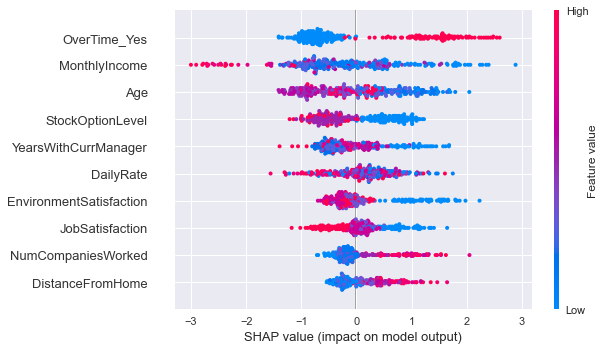

In [33]:
shap.plots.beeswarm(shap_values)

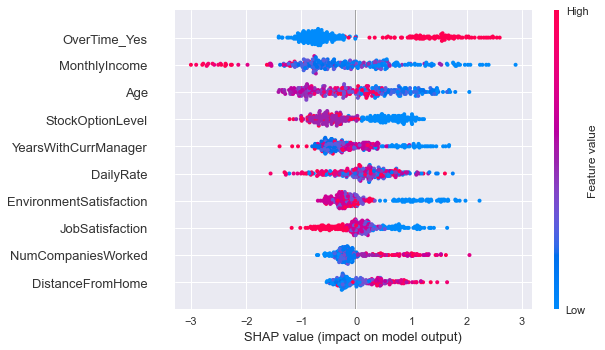

In [82]:
shap.summary_plot(shap_values, x_test[most_important])

In [11]:
explainer(x_test[most_important])

.values =
array([[-0.72381311,  0.13640456,  0.55814345, ...,  0.13612396,
         0.08107867,  0.56792719],
       [-0.9777949 ,  0.60744215, -0.28665433, ...,  0.74694233,
         0.37265203, -0.63634963],
       [ 1.54746796, -0.59339742, -0.4060693 , ...,  0.77664213,
         1.01138749, -0.56655583],
       ...,
       [ 1.24377287,  0.70553514, -1.15704173, ..., -0.23647678,
        -0.26744646,  0.14109054],
       [-0.96030995,  0.26682439, -0.79272441, ..., -0.69270397,
        -0.2907536 ,  0.726517  ],
       [ 1.19684816, -0.69458324, -1.11773645, ...,  0.68684784,
        -0.43183124,  1.18663617]])

.base_values =
array([-3.72099832, -3.72099832, -3.72099832, -3.72099832, -3.72099832,
       -3.72099832, -3.72099832, -3.72099832, -3.72099832, -3.72099832,
       -3.72099832, -3.72099832, -3.72099832, -3.72099832, -3.72099832,
       -3.72099832, -3.72099832, -3.72099832, -3.72099832, -3.72099832,
       -3.72099832, -3.72099832, -3.72099832, -3.72099832, -3.72099832,
 

In [12]:
shap_values.feature_names

['OverTime',
 'StockOptionLevel',
 'MonthlyIncome',
 'JobSatisfaction',
 'NumCompaniesWorked',
 'Age',
 'EnvironmentSatisfaction',
 'DailyRate',
 'DistanceFromHome',
 'YearsWithCurrManager']

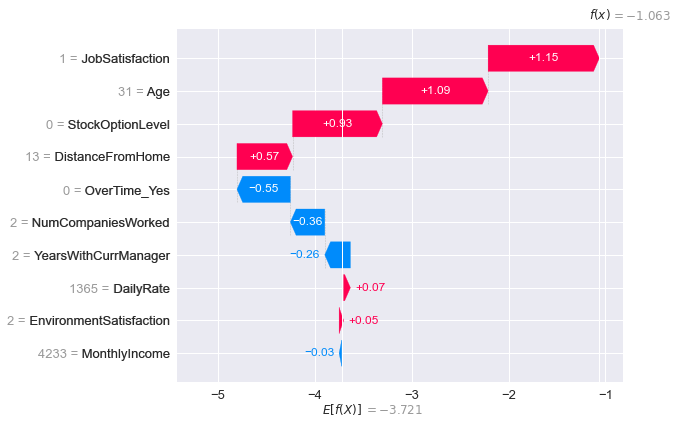

.values =
array([-0.55081115, -0.02727418, -0.35524427,  0.04647569,  1.14763125,
        1.09126111,  0.07021002, -0.26470626,  0.57365041,  0.92698782])

.base_values =
-3.7209983230943466

.data =
array([   0, 4233,    2,    2,    1,   31, 1365,    2,   13,    0],
      dtype=int64)


In [25]:
i = 100

shap.plots.waterfall(shap_values[i])
print(shap_values[i])

In [14]:
shap_values[0]

.values =
array([-0.72381311,  0.13640456,  0.55814345, -0.58515658, -0.16687924,
       -0.58882899, -0.28048321,  0.13612396,  0.08107867,  0.56792719])

.base_values =
-3.7209983230943466

.data =
array([7.17006803e-01, 0.00000000e+00, 9.98000000e+03, 4.00000000e+00,
       1.00000000e+00, 3.60000000e+01, 2.00000000e+00, 6.35000000e+02,
       1.00000000e+01, 7.00000000e+00])